### 데이터 import

In [ ]:
import os
from glob import glob
from typing import Dict, List, Tuple

import sys
import random
from itertools import chain

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (3D 시각화용)
from sklearn.decomposition import PCA
from sklearn.metrics import (
    jaccard_score,
    roc_curve,
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from scipy.ndimage import gaussian_filter

# 프로젝트 루트(CutPaste) 경로를 Python path에 추가해서 로컬 모듈(cutpaste.py, jjs/*.py 등)을 import 가능하게 함
PROJECT_ROOT = "/mnt/home_drive/cjh64866/CutPaste"
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from cutpaste import CutPaste
    
# TODO: 데이터 루트 경로
DATA_ROOT = "/mnt/home_drive/cjh64866/data/mvtec" 

### Train Data 불러오기

In [9]:
# 1. 정상 이미지(256×256×3) 준비
# - MVTec AD 데이터에서 bottle / hazelnut / tile 카테고리의 "train/good" 이미지만 사용

from jjs.data_utils import (
    IMAGE_SIZE,
    DEFAULT_CATEGORIES,
    get_normal_transform,
    collect_normal_image_paths,
    load_image_as_tensor,
) # 데이터 경로

# 사용할 카테고리 (알아서 수정가능)
CATEGORIES = ["bottle", "hazelnut", "tile"]  # 또는 list(DEFAULT_CATEGORIES)

# 공통 이미지 변환(256×256×3)
normal_transform = get_normal_transform(IMAGE_SIZE)

# 정상 이미지 경로 수집
normal_image_paths = collect_normal_image_paths(DATA_ROOT, CATEGORIES)
print("카테고리별 정상 이미지 개수:")
for cat in CATEGORIES:
    print(f" - {cat}: {len(normal_image_paths[cat])}장")


카테고리별 정상 이미지 개수:
 - bottle: 209장
 - hazelnut: 391장
 - tile: 230장


### 학습된 카테고리별(bottle, hazelnut, tile) model(CutPaste를 적용한 ResNet)을 불러와서,
### CutPaste ResNet 3개와 일반(Plain = pretrained) ResNet 3개로 이미지 압축 (256 * 256 * 3 -> 512 차원으로 Feature Extractor 사용)
### 해당 Feature에 대한 GDE 생성

In [ ]:
# 2. 카테고리별( bottle / hazelnut / tile ) CutPaste ResNet / Plain ResNet Gaussian 학습
# - 학습은 하지 않고, 미리 학습된 checkpoint(ckpt)를 로드해서 feature extractor 로만 사용
# - 각 카테고리의 정상 train 이미지를 사용해
#   1) CutPaste 전용 ResNet (카테고리별 ckpt) → Gaussian
#   2) 공통 Plain ResNet (ImageNet pretrained) → Gaussian

import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models

# jjs 패키지를 어디서 실행하든 찾을 수 있도록 PROJECT_ROOT 를 sys.path 에 추가
PROJECT_ROOT = "/mnt/home_drive/cjh64866/CutPaste"
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from jjs.cutpaste_train import CutPasteBinaryResNet
from jjs.feature_gaussian import NormalImageDataset, extract_features, fit_gaussian


# normal_image_paths / CATEGORIES / normal_transform 이 없더라도 이 셀만으로 동작할 수 있게 보완
if "CATEGORIES" not in globals():
    CATEGORIES = ["bottle", "hazelnut", "tile"]

try:
    _ = normal_transform  # noqa: F821
except NameError:
    from jjs.data_utils import IMAGE_SIZE, get_normal_transform
    normal_transform = get_normal_transform(IMAGE_SIZE)

try:
    _ = normal_image_paths  # noqa: F821
except NameError:
    from jjs.data_utils import collect_normal_image_paths
    normal_image_paths = collect_normal_image_paths(DATA_ROOT, CATEGORIES)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("사용 디바이스:", device)

# -------------------------
# 3-1. 카테고리별 CutPaste ResNet backbone 로드
# -------------------------

CKPT_ROOT = "/mnt/home_drive/cjh64866/CutPaste/jjs/models"
ckpt_paths = {
    "bottle": f"{CKPT_ROOT}/bottle/bottle_20251214_205440.ckpt",
    "hazelnut": f"{CKPT_ROOT}/hazelnut/hazelnut_20251214_213624.ckpt",
    "tile": f"{CKPT_ROOT}/tile/tile_20251214_220039.ckpt",
}


def load_backbone_from_ckpt(ckpt_path: str) -> nn.Module:
    """단일 tch 파일에서 CutPasteBinaryResNet backbone (512-d feature extractor) 를 로드.

    - tch 형식이 LightningModule(state_dict 포함) 이라고 가정하고, 'state_dict' 키가 있으면 사용.
    - 필요한 경우 'model.' prefix 를 제거하도록 처리.
    """
    model = CutPasteBinaryResNet(pretrained=False, num_classes=2)
    ckpt = torch.load(ckpt_path, map_location=device)

    state_dict = ckpt.get("state_dict", ckpt)
    new_state_dict = {}
    for k, v in state_dict.items():
        # Lightning에서 흔히 붙는 'model.' prefix 제거
        if k.startswith("model."):
            k = k[len("model."):]
        new_state_dict[k] = v

    model.load_state_dict(new_state_dict, strict=False)
    return model.backbone.to(device).eval()


# 카테고리별 CutPaste backbone 준비
cutpaste_backbones = {}
for cat in ["bottle", "hazelnut", "tile"]:
    path = ckpt_paths[cat]
    print(f"[CutPaste] {cat} tch 로드: {path}")
    cutpaste_backbones[cat] = load_backbone_from_ckpt(path)


# -------------------------
# 3-2. 카테고리별 정상 이미지 → CutPaste feature → Gaussian
# -------------------------

BATCH_SIZE_FEAT = 64

features_cutpaste_by_cat = {}
gaussians_cutpaste_by_cat = {}

for cat in ["bottle", "hazelnut", "tile"]:
    paths = normal_image_paths[cat]
    print(f"[CutPaste] 카테고리 '{cat}' 정상 이미지 {len(paths)}장 feature 추출 중...")

    dataset = NormalImageDataset(paths, transform=normal_transform)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE_FEAT, shuffle=False, num_workers=4)

    feats = extract_features(cutpaste_backbones[cat], loader, device)
    features_cutpaste_by_cat[cat] = feats
    gaussians_cutpaste_by_cat[cat] = fit_gaussian(feats)

    print(f"  -> feature shape: {feats.shape}, Gaussian(mu, Σ) 완성")


# -------------------------
# 3-3. 공통 Plain ResNet backbone 준비 (ImageNet pretrained)
# -------------------------

plain_resnet = models.resnet18(pretrained=True)
plain_resnet.fc = nn.Identity()  # 512-d feature만 출력
plain_resnet = plain_resnet.to(device).eval()


# -------------------------
# 3-4. 카테고리별 정상 이미지 → Plain ResNet feature → Gaussian
# -------------------------

features_plain_by_cat = {}
gaussians_plain_by_cat = {}

for cat in ["bottle", "hazelnut", "tile"]:
    paths = normal_image_paths[cat]
    print(f"[Plain] 카테고리 '{cat}' 정상 이미지 {len(paths)}장 feature 추출 중...")

    dataset = NormalImageDataset(paths, transform=normal_transform)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE_FEAT, shuffle=False, num_workers=4)

    feats = extract_features(plain_resnet, loader, device)
    features_plain_by_cat[cat] = feats
    gaussians_plain_by_cat[cat] = fit_gaussian(feats)

    print(f"  -> feature shape: {feats.shape}, Gaussian(mu, Σ) 완성")


print("\n[정리] 카테고리별 Gaussian 모델 변수:")
for cat in ["bottle", "hazelnut", "tile"]:
    print(f"- {cat}: CutPaste → gaussians_cutpaste_by_cat['{cat}'], Plain → gaussians_plain_by_cat['{cat}']")



사용 디바이스: cuda
[CutPaste] bottle tch 로드: /mnt/home_drive/cjh64866/CutPaste/jjs/models/bottle/bottle_20251214_205440.ckpt
[CutPaste] hazelnut tch 로드: /mnt/home_drive/cjh64866/CutPaste/jjs/models/hazelnut/hazelnut_20251214_213624.ckpt
[CutPaste] tile tch 로드: /mnt/home_drive/cjh64866/CutPaste/jjs/models/tile/tile_20251214_220039.ckpt
[CutPaste] 카테고리 'bottle' 정상 이미지 209장 feature 추출 중...
  -> feature shape: (209, 512), Gaussian(mu, Σ) 완성
[CutPaste] 카테고리 'hazelnut' 정상 이미지 391장 feature 추출 중...
  -> feature shape: (391, 512), Gaussian(mu, Σ) 완성
[CutPaste] 카테고리 'tile' 정상 이미지 230장 feature 추출 중...
  -> feature shape: (230, 512), Gaussian(mu, Σ) 완성
[Plain] 카테고리 'bottle' 정상 이미지 209장 feature 추출 중...
  -> feature shape: (209, 512), Gaussian(mu, Σ) 완성
[Plain] 카테고리 'hazelnut' 정상 이미지 391장 feature 추출 중...
  -> feature shape: (391, 512), Gaussian(mu, Σ) 완성
[Plain] 카테고리 'tile' 정상 이미지 230장 feature 추출 중...
  -> feature shape: (230, 512), Gaussian(mu, Σ) 완성

[정리] 카테고리별 Gaussian 모델 변수:
- bottle: CutPaste → gaus

### Test Data에서 정상 데이터와 비정상 데이터로 각 GDE 모델의 성능 평가

Threshold Q: 0.98 (tail의 0.02만큼 이상치로)

차이는 미미하지만 CutPaste가 약간 더 성능 우위

보고서 쓸 때:
논문에서는 CutPaste ResNet을 구분하여 일반 binary, scar, 3-way 3개로 비교 실험을 진행하였는데, 우리는 CutPaste의 ResNet 중 일반 binary만 가지고 실험을 진행하였다. 이에 따라 Hazelnut에 scar 형식의 이상치가 존재할 경우의 탐지 능력이 CutPaste binary ResNet과 Plain ResNet 모두 떨어지는 경향을 보였다.
기회가 된다면 이런 부분을 좀 더 잘 해보고 싶다~ 느낌으로다가 싹싹김치로 잘 적어주시면 좋을 것 같아요

[TestDataset] bottle: total=62 (good+defect)
[TestDataset] hazelnut: total=110 (good+defect)
[TestDataset] tile: total=117 (good+defect)

[평가] Category = bottle

[평가] Category = hazelnut

[평가] Category = tile


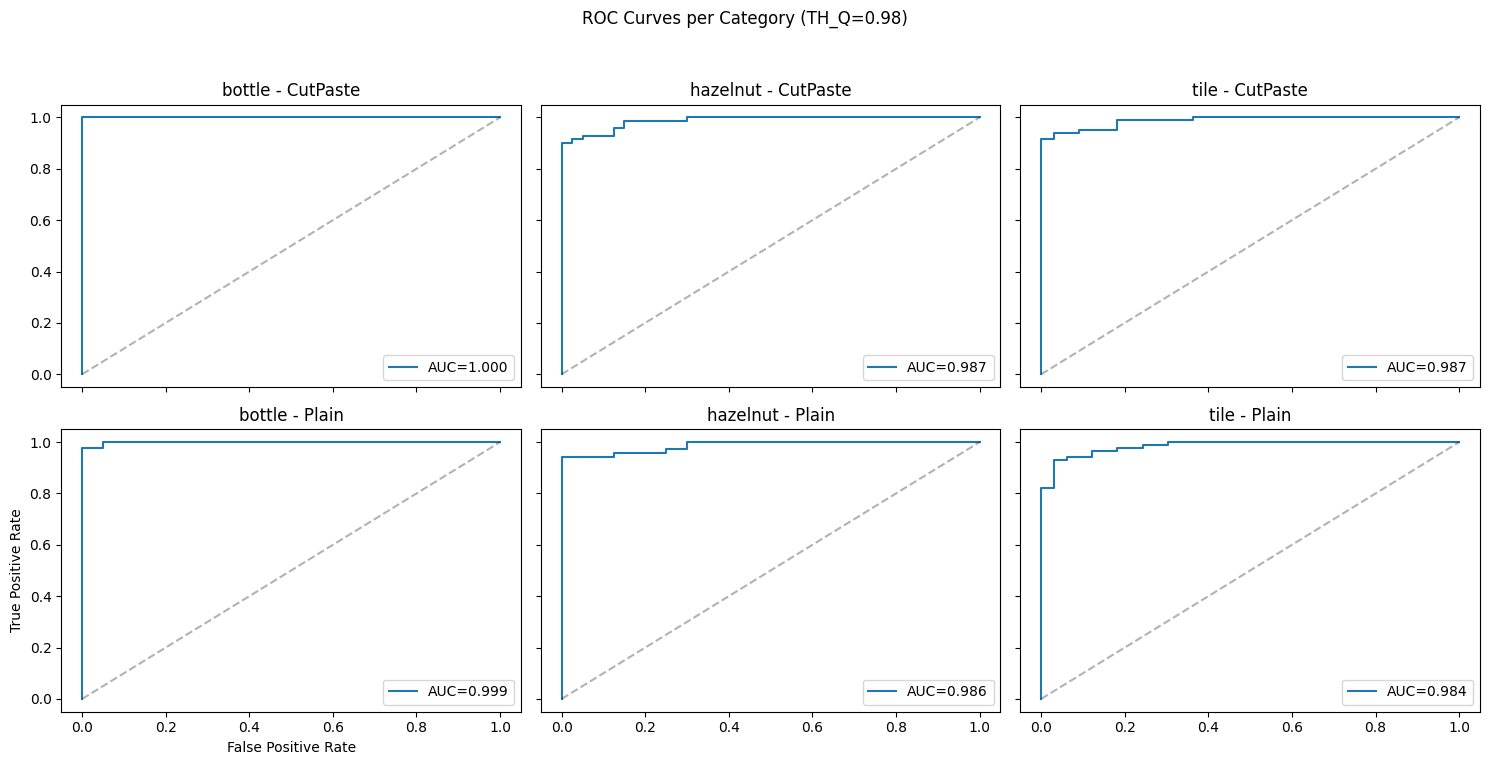

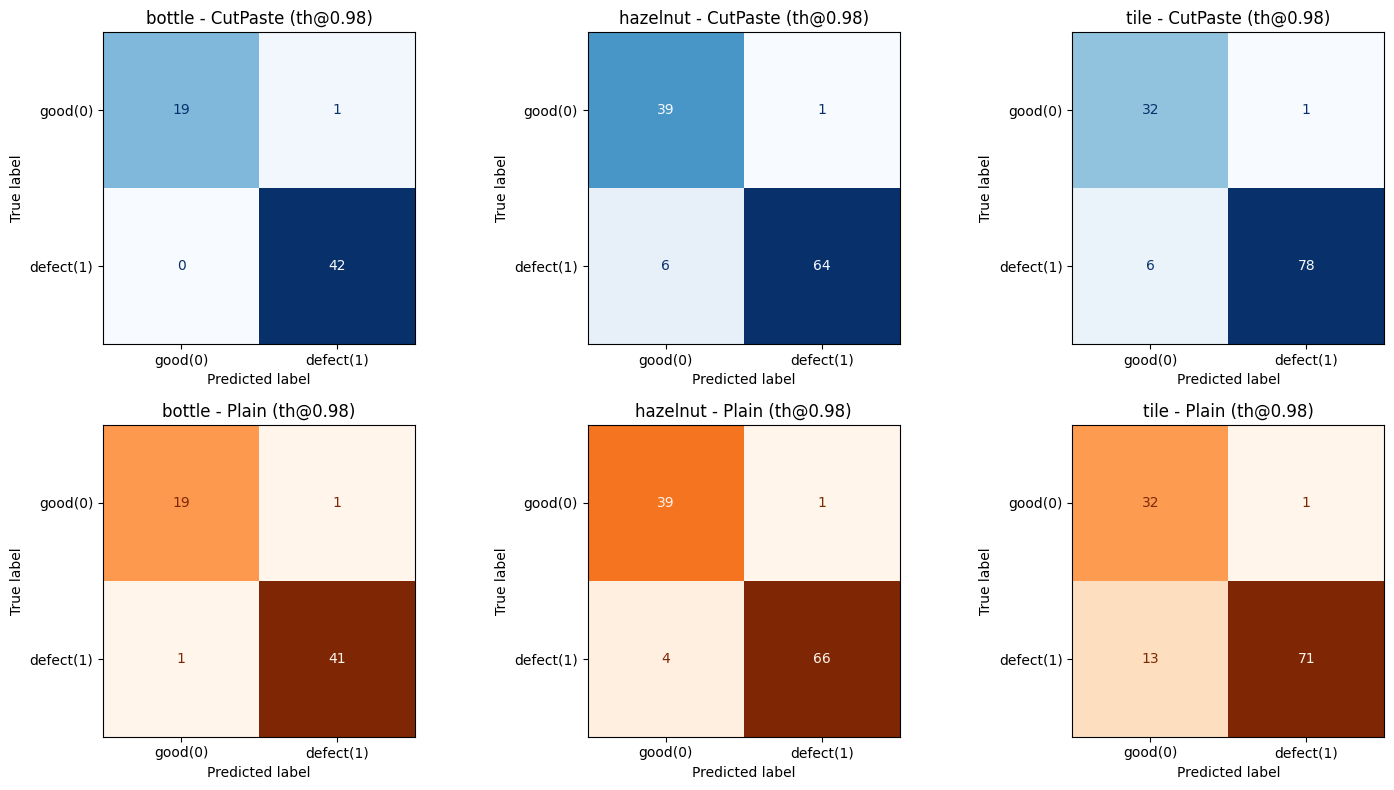

In [ ]:
# 4. 카테고리별 Gaussian 기반 anomaly 검증 (CutPaste vs Plain)
# - 3번 셀에서 만든 gaussians_cutpaste_by_cat / gaussians_plain_by_cat 를 사용
# - 각 카테고리의 test/good vs test/(기타 defect 폴더, contamination 제외) 에 대해
#   ROC-AUC와 Confusion Matrix 를 CutPaste / Plain 각각 계산 및 시각화

from dataclasses import dataclass
from typing import Dict, List, Tuple

THRESHOLD_Q = 0.98 # 정상(label=0) 점수 분포의 상위 몇 %를 threshold 로 사용할지 (예: 0.9 → 상위 10%)

IMAGE_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tiff", ".tif"}


@dataclass
class EvalResult:
    labels: np.ndarray
    scores_cut: np.ndarray
    scores_plain: np.ndarray
    th_cut: float
    th_plain: float
    cm_cut: np.ndarray
    cm_plain: np.ndarray
    roc_cut: Tuple[np.ndarray, np.ndarray, float]
    roc_plain: Tuple[np.ndarray, np.ndarray, float]


class CategoryTestDataset(Dataset):
    """단일 카테고리의 test/good + defect 이미지를 로드하는 Dataset.

    - good 폴더는 label=0
    - test 하위에서 'good', 'contamination' 를 제외한 모든 폴더는 defect(label=1)
    """

    def __init__(self, root: str, category: str, transform):
        self.items: List[Tuple[str, int]] = []
        test_root = os.path.join(root, category, "test")
        if os.path.isdir(test_root):
            for defect_type in sorted(os.listdir(test_root)):
                defect_dir = os.path.join(test_root, defect_type)
                if not os.path.isdir(defect_dir):
                    continue
                if defect_type == "contamination":  # GT mask 폴더 등은 제외
                    continue
                label = 0 if defect_type == "good" else 1
                for path in glob(os.path.join(defect_dir, "*")):
                    ext = os.path.splitext(path.lower())[1]
                    if ext in IMAGE_EXTS:
                        self.items.append((path, label))

        print(f"[TestDataset] {category}: total={len(self.items)} (good+defect)")
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        path, label = self.items[idx]
        img = Image.open(path).convert("RGB")
        x = self.transform(img)
        return x, label, path


def build_test_loaders(root: str, categories: List[str], transform, batch_size: int = 64) -> Dict[str, DataLoader]:
    loaders: Dict[str, DataLoader] = {}
    for cat in categories:
        ds = CategoryTestDataset(root, cat, transform)
        loaders[cat] = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=4)
    return loaders


def mahalanobis_scores(features: np.ndarray, mu: np.ndarray, cov: np.ndarray) -> np.ndarray:
    """다변량 가우시안(μ, Σ)에 대한 Mahalanobis 거리^2 를 anomaly score로 사용."""
    diff = features - mu[None, :]
    inv_cov = np.linalg.inv(cov)
    scores = np.einsum("ij,jk,ik->i", diff, inv_cov, diff)
    return scores


class GaussianEvaluator:
    """카테고리별 CutPaste / Plain Gaussian 을 사용해 anomaly score 를 평가하는 helper."""

    def __init__(
        self,
        gaussians_cutpaste_by_cat: Dict[str, Dict[str, np.ndarray]],
        gaussians_plain_by_cat: Dict[str, Dict[str, np.ndarray]],
        cutpaste_backbones: Dict[str, nn.Module],
        plain_resnet: nn.Module,
        device: torch.device,
    ):
        self.gaussians_cutpaste_by_cat = gaussians_cutpaste_by_cat
        self.gaussians_plain_by_cat = gaussians_plain_by_cat
        self.cutpaste_backbones = cutpaste_backbones
        self.plain_resnet = plain_resnet
        self.device = device

    def evaluate_category(self, category: str, loader: DataLoader) -> EvalResult:
        from sklearn.metrics import roc_curve, auc, confusion_matrix

        backbone_cp = self.cutpaste_backbones[category].to(self.device).eval()
        g_cp = self.gaussians_cutpaste_by_cat[category]
        g_pl = self.gaussians_plain_by_cat[category]

        all_labels: List[np.ndarray] = []
        all_scores_cp: List[np.ndarray] = []
        all_scores_pl: List[np.ndarray] = []

        with torch.no_grad():
            for imgs, labels, paths in loader:
                imgs = imgs.to(self.device)

                feats_cp = backbone_cp(imgs).cpu().numpy()
                feats_pl = self.plain_resnet(imgs).cpu().numpy()

                scores_cp = mahalanobis_scores(feats_cp, g_cp["mu"], g_cp["cov"])
                scores_pl = mahalanobis_scores(feats_pl, g_pl["mu"], g_pl["cov"])

                all_labels.append(labels.numpy())
                all_scores_cp.append(scores_cp)
                all_scores_pl.append(scores_pl)

        labels = np.concatenate(all_labels)
        scores_cp = np.concatenate(all_scores_cp)
        scores_pl = np.concatenate(all_scores_pl)

        # ROC
        fpr_cp, tpr_cp, _ = roc_curve(labels, scores_cp)
        auc_cp = auc(fpr_cp, tpr_cp)
        fpr_pl, tpr_pl, _ = roc_curve(labels, scores_pl)
        auc_pl = auc(fpr_pl, tpr_pl)

        # threshold (good label=0 기준)
        normal_mask = labels == 0
        th_cp = float(np.quantile(scores_cp[normal_mask], THRESHOLD_Q))
        th_pl = float(np.quantile(scores_pl[normal_mask], THRESHOLD_Q))

        pred_cp = scores_cp > th_cp
        pred_pl = scores_pl > th_pl

        cm_cp = confusion_matrix(labels, pred_cp.astype(int), labels=[0, 1])
        cm_pl = confusion_matrix(labels, pred_pl.astype(int), labels=[0, 1])

        return EvalResult(
            labels=labels,
            scores_cut=scores_cp,
            scores_plain=scores_pl,
            th_cut=th_cp,
            th_plain=th_pl,
            cm_cut=cm_cp,
            cm_plain=cm_pl,
            roc_cut=(fpr_cp, tpr_cp, auc_cp),
            roc_plain=(fpr_pl, tpr_pl, auc_pl),
        )

    def evaluate_all(self, loaders: Dict[str, DataLoader]) -> Dict[str, EvalResult]:
        results: Dict[str, EvalResult] = {}
        for cat, loader in loaders.items():
            print(f"\n[평가] Category = {cat}")
            results[cat] = self.evaluate_category(cat, loader)
        return results


# -------------------------
# 4-1. test loader 준비
# -------------------------

test_loaders = build_test_loaders(DATA_ROOT, CATEGORIES, normal_transform, batch_size=64)

evaluator = GaussianEvaluator(
    gaussians_cutpaste_by_cat=gaussians_cutpaste_by_cat,
    gaussians_plain_by_cat=gaussians_plain_by_cat,
    cutpaste_backbones=cutpaste_backbones,
    plain_resnet=plain_resnet,
    device=device,
)

results_by_cat = evaluator.evaluate_all(test_loaders)


# -------------------------
# 4-2. ROC-AUC 시각화 (2행×3열: 위=CutPaste, 아래=Plain)
# -------------------------

fig, axes = plt.subplots(2, len(CATEGORIES), figsize=(15, 8), sharex=True, sharey=True)

for j, cat in enumerate(CATEGORIES):
    res = results_by_cat[cat]
    fpr_cp, tpr_cp, auc_cp = res.roc_cut
    fpr_pl, tpr_pl, auc_pl = res.roc_plain

    ax_cp = axes[0, j]
    ax_pl = axes[1, j]

    ax_cp.plot(fpr_cp, tpr_cp, label=f"AUC={auc_cp:.3f}")
    ax_cp.plot([0, 1], [0, 1], "k--", alpha=0.3)
    ax_cp.set_title(f"{cat} - CutPaste")
    ax_cp.legend()

    ax_pl.plot(fpr_pl, tpr_pl, label=f"AUC={auc_pl:.3f}")
    ax_pl.plot([0, 1], [0, 1], "k--", alpha=0.3)
    ax_pl.set_title(f"{cat} - Plain")
    ax_pl.legend()

axes[1, 0].set_xlabel("False Positive Rate")
axes[1, 0].set_ylabel("True Positive Rate")
plt.suptitle(f"ROC Curves per Category (TH_Q={THRESHOLD_Q})")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# -------------------------
# 4-3. Confusion Matrix 시각화 (2행×3열)
# -------------------------

fig_cm, axes_cm = plt.subplots(2, len(CATEGORIES), figsize=(15, 8))

for j, cat in enumerate(CATEGORIES):
    res = results_by_cat[cat]

    cm_cp = res.cm_cut
    cm_pl = res.cm_plain

    disp_cp = ConfusionMatrixDisplay(cm_cp, display_labels=["good(0)", "defect(1)"])
    disp_cp.plot(ax=axes_cm[0, j], cmap="Blues", values_format="d", colorbar=False)
    axes_cm[0, j].set_title(f"{cat} - CutPaste (th@{THRESHOLD_Q:.2f})")

    disp_pl = ConfusionMatrixDisplay(cm_pl, display_labels=["good(0)", "defect(1)"])
    disp_pl.plot(ax=axes_cm[1, j], cmap="Oranges", values_format="d", colorbar=False)
    axes_cm[1, j].set_title(f"{cat} - Plain (th@{THRESHOLD_Q:.2f})")

plt.tight_layout()
plt.show()

### 어디가 이상 cell인지 확인하는 Localization 작업

아까와 같은 방식으로 GDE 모델 6개 학습

In [12]:
# 5. 카테고리별 패치 기반 Gaussian 학습 (CutPaste / Plain)
# - 각 카테고리의 정상 이미지(256×256)를 64×64 패치 16개로 나눈 뒤
#   CutPaste / Plain feature extractor 를 통과시켜 패치 feature Gaussian(μ, Σ)을 학습

from torchvision import transforms

PATCH_SIZE = 64

# 패치용 transform (ResNet ImageNet 정규화 기준)
patch_transform = transforms.Compose([
    transforms.Resize((PATCH_SIZE, PATCH_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


def extract_patches_64(img_pil, patch_size: int = 64):
    """256×256 이미지에서 64×64 non-overlapping 패치 16개를 추출."""
    w, h = img_pil.size
    if (w, h) != (256, 256):
        img_pil = img_pil.resize((256, 256))
        w, h = img_pil.size
    patches = []
    for top in range(0, h, patch_size):
        for left in range(0, w, patch_size):
            box = (left, top, left + patch_size, top + patch_size)
            patches.append(img_pil.crop(box))
    return patches


device_patch = device  # 3번 셀에서 사용한 device 그대로 사용

# 결과를 저장할 딕셔너리 (총 6개 Gaussian 모델)
patch_features_cutpaste_by_cat = {}
patch_features_plain_by_cat = {}
patch_gaussians_cutpaste_by_cat = {}
patch_gaussians_plain_by_cat = {}

for cat in CATEGORIES:
    paths = normal_image_paths[cat]
    print(f"\n[Patch-Gaussian] 카테고리 '{cat}' 정상 이미지 {len(paths)}장 처리 중...")

    patch_feats_cut = []
    patch_feats_plain = []

    backbone_cut = cutpaste_backbones[cat].to(device_patch).eval()
    backbone_plain = plain_resnet.to(device_patch).eval()

    with torch.no_grad():
        for path in paths:
            img = Image.open(path).convert("RGB")
            img = img.resize((256, 256))
            patches = extract_patches_64(img, PATCH_SIZE)

            batch = torch.stack([patch_transform(p) for p in patches]).to(device_patch)

            feats_cut = backbone_cut(batch).cpu().numpy()    # (16, 512)
            feats_plain = backbone_plain(batch).cpu().numpy()  # (16, 512)

            patch_feats_cut.append(feats_cut)
            patch_feats_plain.append(feats_plain)

    patch_feats_cut = np.concatenate(patch_feats_cut, axis=0)   # (N_patches, 512)
    patch_feats_plain = np.concatenate(patch_feats_plain, axis=0)

    patch_features_cutpaste_by_cat[cat] = patch_feats_cut
    patch_features_plain_by_cat[cat] = patch_feats_plain

    # jjs.feature_gaussian.fit_gaussian 을 사용해 Gaussian(μ, Σ) 추정
    patch_gaussians_cutpaste_by_cat[cat] = fit_gaussian(patch_feats_cut)
    patch_gaussians_plain_by_cat[cat] = fit_gaussian(patch_feats_plain)

    print(f"  -> CutPaste 패치 feature shape: {patch_feats_cut.shape}, Gaussian(mu, Σ) 완료")
    print(f"  -> Plain   패치 feature shape: {patch_feats_plain.shape}, Gaussian(mu, Σ) 완료")

print("\n[정리] 패치 기반 Gaussian 변수 이름:")
for cat in CATEGORIES:
    print(f"- {cat}: CutPaste → patch_gaussians_cutpaste_by_cat['{cat}'], Plain → patch_gaussians_plain_by_cat['{cat}']")




[Patch-Gaussian] 카테고리 'bottle' 정상 이미지 209장 처리 중...
  -> CutPaste 패치 feature shape: (3344, 512), Gaussian(mu, Σ) 완료
  -> Plain   패치 feature shape: (3344, 512), Gaussian(mu, Σ) 완료

[Patch-Gaussian] 카테고리 'hazelnut' 정상 이미지 391장 처리 중...
  -> CutPaste 패치 feature shape: (6256, 512), Gaussian(mu, Σ) 완료
  -> Plain   패치 feature shape: (6256, 512), Gaussian(mu, Σ) 완료

[Patch-Gaussian] 카테고리 'tile' 정상 이미지 230장 처리 중...
  -> CutPaste 패치 feature shape: (3680, 512), Gaussian(mu, Σ) 완료
  -> Plain   패치 feature shape: (3680, 512), Gaussian(mu, Σ) 완료

[정리] 패치 기반 Gaussian 변수 이름:
- bottle: CutPaste → patch_gaussians_cutpaste_by_cat['bottle'], Plain → patch_gaussians_plain_by_cat['bottle']
- hazelnut: CutPaste → patch_gaussians_cutpaste_by_cat['hazelnut'], Plain → patch_gaussians_plain_by_cat['hazelnut']
- tile: CutPaste → patch_gaussians_cutpaste_by_cat['tile'], Plain → patch_gaussians_plain_by_cat['tile']


### 시각화용 함수 정의

In [ ]:
# 6. 패치 기반 heatmap 계산 helper (CutPaste / Plain 공용)
# - 4번 셀에서 만든 patch_gaussians_*_by_cat, cutpaste_backbones, plain_resnet 를 사용
# - 아래 7번 셀에서 재사용

import torch
import numpy as np
from PIL import Image
from scipy.ndimage import gaussian_filter
import torch.nn.functional as F


def compute_patch_heatmap_64x64_cat(
    defect_img_path: str,
    cat: str,
    model: str = "cutpaste",
    smooth: bool = True,
    sigma: float = 2.0,
) -> np.ndarray:
    """단일 defect 이미지에 대해 [0,1] 범위의 256×256 heatmap 생성.

    - model: 'cutpaste' 또는 'plain'
    - cat: 카테고리 이름 (bottle / hazelnut / tile)
    """
    # 256×256 이미지 준비
    img_pil = Image.open(defect_img_path).convert("RGB")
    img_pil = img_pil.resize((256, 256))
    patches = extract_patches_64(img_pil, PATCH_SIZE)  # 16개 패치

    # 디바이스/transform 은 4번 셀에서 정의된 것을 재사용
    batch = torch.stack([patch_transform(p) for p in patches]).to(device_patch)

    # backbone / Gaussian 선택
    if model == "cutpaste":
        if "cutpaste_backbones" not in globals() or "patch_gaussians_cutpaste_by_cat" not in globals():
            raise RuntimeError("cutpaste_backbones / patch_gaussians_cutpaste_by_cat 가 정의되어 있지 않습니다. 2, 4번 셀을 먼저 실행하세요.")
        backbone = cutpaste_backbones[cat].to(device_patch).eval()
        gaussian = patch_gaussians_cutpaste_by_cat[cat]
    elif model == "plain":
        if "plain_resnet" not in globals() or "patch_gaussians_plain_by_cat" not in globals():
            raise RuntimeError("plain_resnet / patch_gaussians_plain_by_cat 가 정의되어 있지 않습니다. 2, 4번 셀을 먼저 실행하세요.")
        backbone = plain_resnet.to(device_patch).eval()
        gaussian = patch_gaussians_plain_by_cat[cat]
    else:
        raise ValueError("model 은 'cutpaste' 또는 'plain' 이어야 합니다.")

    with torch.no_grad():
        feats = backbone(batch).cpu().numpy()  # (16, 512)

    # Mahalanobis score → 4×4 grid
    diff = feats - gaussian["mu"][None, :]
    inv_cov = np.linalg.inv(gaussian["cov"])
    scores = np.einsum("ij,jk,ik->i", diff, inv_cov, diff)  # (16,)
    grid = scores.reshape(4, 4)

    # 0~1 정규화
    grid = (grid - grid.min()) / (grid.max() - grid.min() + 1e-8)

    # bilinear 업샘플 (4×4 → 256×256)
    grid_t = torch.from_numpy(grid).float().unsqueeze(0).unsqueeze(0)  # (1,1,4,4)
    heat = F.interpolate(grid_t, size=(256, 256), mode="bilinear", align_corners=False)
    heat = heat.squeeze().numpy()

    if smooth:
        heat = gaussian_filter(heat, sigma=sigma)
        heat = (heat - heat.min()) / (heat.max() - heat.min() + 1e-8)

    return heat.astype(np.float32)



### 시각화

빨간색 윤곽선: 정답 mask  
파란색 hitmap: prediction  
threshold: 0.5로 classification (이진화)  

IoU: 빨간색 윤곽선 안에 파란색 hitmap이 얼마나 겹쳤는지에 따른 score (높을 수록 좋음)

같은 이미지 데이터에 대한 CutPaste ResNet(위) vs Plain ResNet(아래) 비교


=== Category: bottle (고정 샘플, thr=0.50) ===
[샘플] /mnt/home_drive/cjh64866/data/mvtec/bottle/test/broken_large/004.png
모델=CutPaste, cat=bottle, smooth=True, thr=0.50 → IoU=0.367
이미지: /mnt/home_drive/cjh64866/data/mvtec/bottle/test/broken_large/004.png
GT   : /mnt/home_drive/cjh64866/data/mvtec/bottle/ground_truth/broken_large/004_mask.png
모델=Plain, cat=bottle, smooth=True, thr=0.50 → IoU=0.223
이미지: /mnt/home_drive/cjh64866/data/mvtec/bottle/test/broken_large/004.png
GT   : /mnt/home_drive/cjh64866/data/mvtec/bottle/ground_truth/broken_large/004_mask.png


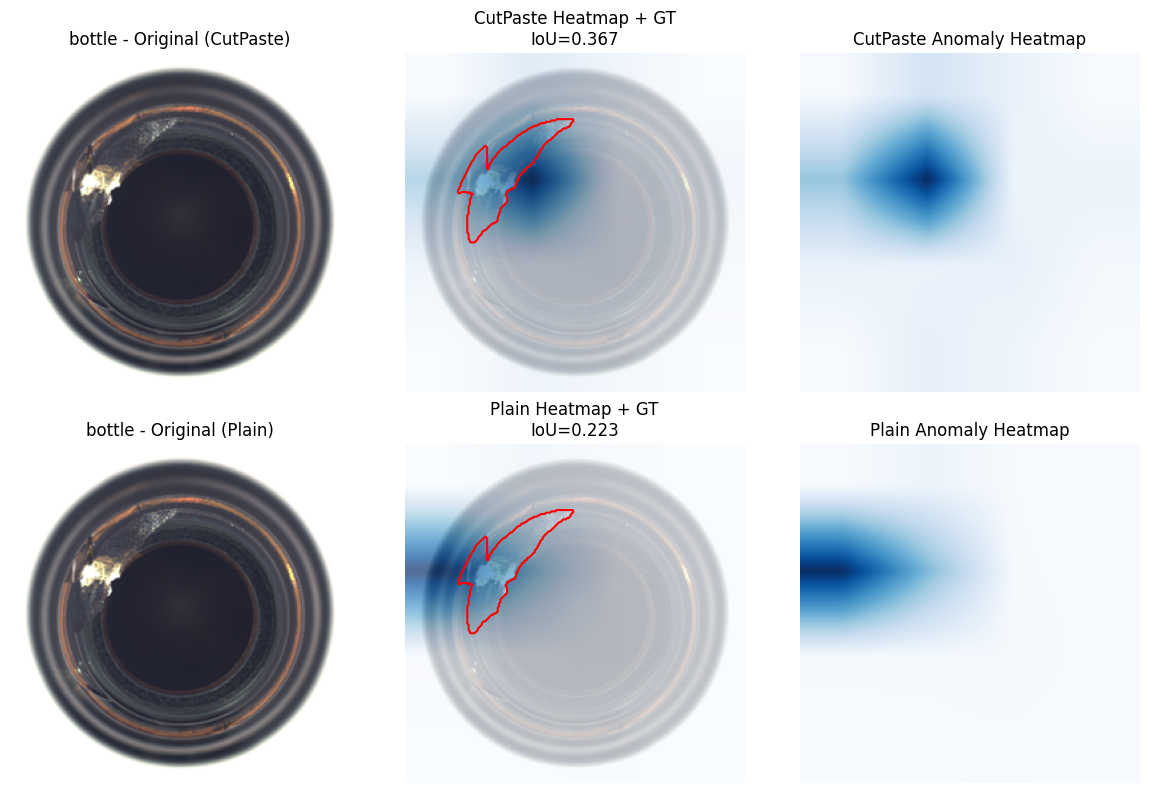


=== Category: hazelnut (고정 샘플, thr=0.50) ===
[샘플] /mnt/home_drive/cjh64866/data/mvtec/hazelnut/test/crack/008.png
모델=CutPaste, cat=hazelnut, smooth=True, thr=0.50 → IoU=0.458
이미지: /mnt/home_drive/cjh64866/data/mvtec/hazelnut/test/crack/008.png
GT   : /mnt/home_drive/cjh64866/data/mvtec/hazelnut/ground_truth/crack/008_mask.png
모델=Plain, cat=hazelnut, smooth=True, thr=0.50 → IoU=0.618
이미지: /mnt/home_drive/cjh64866/data/mvtec/hazelnut/test/crack/008.png
GT   : /mnt/home_drive/cjh64866/data/mvtec/hazelnut/ground_truth/crack/008_mask.png


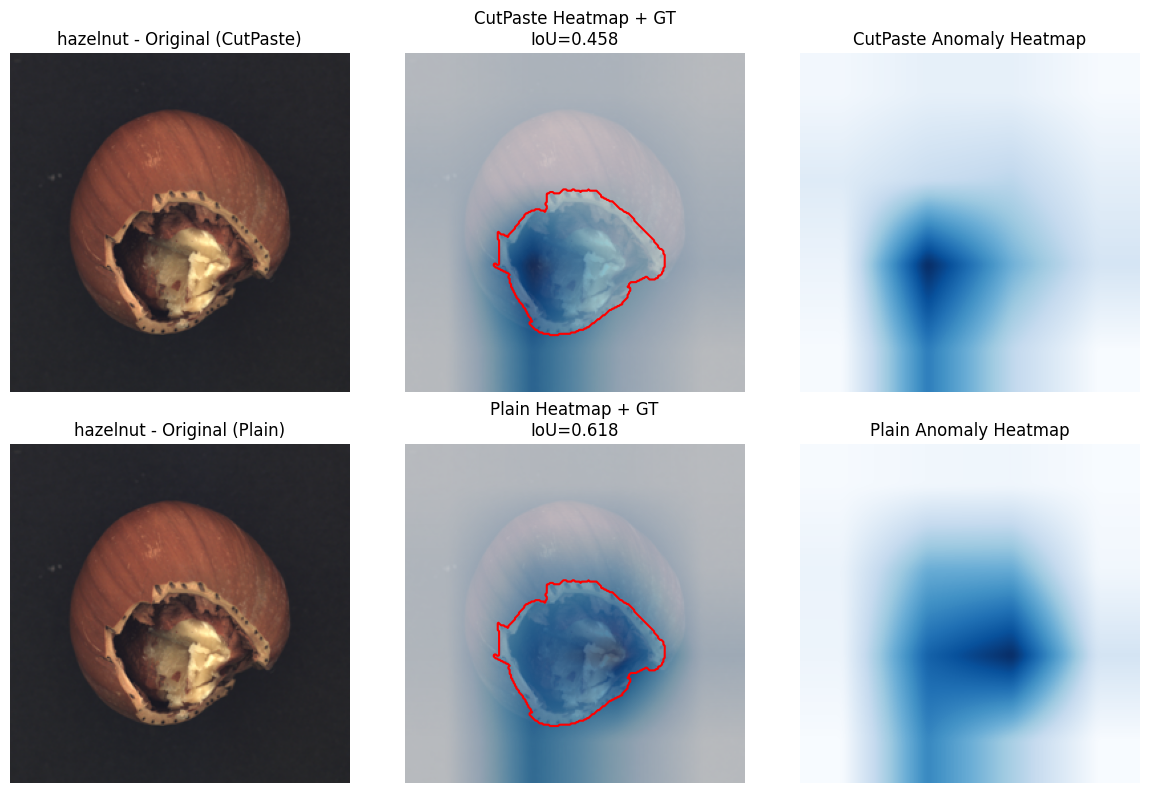


=== Category: tile (고정 샘플, thr=0.50) ===
[샘플] /mnt/home_drive/cjh64866/data/mvtec/tile/test/rough/006.png
모델=CutPaste, cat=tile, smooth=True, thr=0.50 → IoU=0.851
이미지: /mnt/home_drive/cjh64866/data/mvtec/tile/test/rough/006.png
GT   : /mnt/home_drive/cjh64866/data/mvtec/tile/ground_truth/rough/006_mask.png
모델=Plain, cat=tile, smooth=True, thr=0.50 → IoU=0.698
이미지: /mnt/home_drive/cjh64866/data/mvtec/tile/test/rough/006.png
GT   : /mnt/home_drive/cjh64866/data/mvtec/tile/ground_truth/rough/006_mask.png


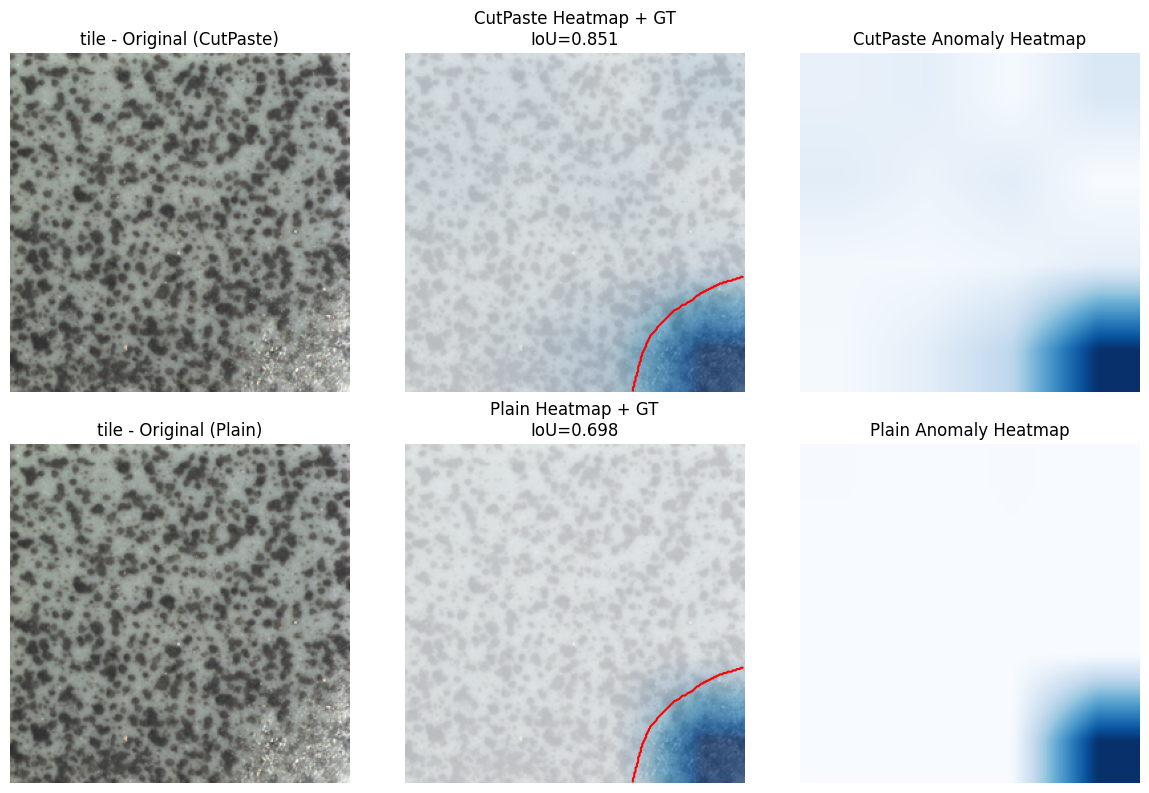

In [21]:
# 7. 동일 defect 이미지에 대해 CutPaste vs Plain을 한 Figure(2×3)로 비교 시각화
# - good / contamination 제외
# - 위 행: CutPaste ResNet, 아래 행: Plain ResNet

import os
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import jaccard_score

# DATA_ROOT / CATEGORIES 기본값 (커널 리셋 대비)
if "DATA_ROOT" not in globals():
    DATA_ROOT = "/mnt/home_drive/cjh64866/data/mvtec"

if "CATEGORIES" not in globals():
    CATEGORIES = ["bottle", "hazelnut", "tile"]

# THR_PATCH 기본값 (항상 이 값으로 덮어쓰기)
THR_PATCH = 0.5


IMAGE_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tiff", ".tif"}


# 7-1. defect 경로 → GT 마스크 경로 (test.ipynb와 동일 로직)

def get_gt_mask_path(defect_img_path: str) -> str:
    rel = os.path.relpath(defect_img_path, DATA_ROOT)
    parts = rel.split(os.sep)
    if len(parts) < 4 or parts[1] != "test":
        raise ValueError(f"예상치 못한 MVTec 경로 구조입니다: {defect_img_path}")
    category = parts[0]
    defect_type = parts[2]
    fname = parts[3]

    base, ext = os.path.splitext(fname)
    mask_name = base + "_mask" + ext

    gt_root = os.path.join(DATA_ROOT, category, "ground_truth")
    if not os.path.isdir(gt_root):
        alt_gt_root = os.path.join(DATA_ROOT, category, "groundtruth")
        if os.path.isdir(alt_gt_root):
            gt_root = alt_gt_root

    mask_dir = os.path.join(gt_root, defect_type)
    return os.path.join(mask_dir, mask_name)


# 7-2. 단일 defect 이미지에 대해 CutPaste vs Plain 2×3 Figure로 시각화

def visualize_defect_pair_cat(
    defect_img_path: str,
    cat: str,
    smooth: bool = True,
    thr: float = THR_PATCH,
):
    """동일 defect 이미지에 대해 CutPaste / Plain 을 한 Figure(2×3)로 비교 시각화 + IoU 출력.

    각 행: 모델(CutPaste / Plain)
    각 열: [Original, Heatmap+GT, Heatmap-only]
    """
    img = Image.open(defect_img_path).convert("RGB")
    img = img.resize((256, 256))

    # GT 마스크 로드
    gt_path = get_gt_mask_path(defect_img_path)
    if not os.path.exists(gt_path):
        print(f"[경고] GT 마스크를 찾을 수 없습니다: {gt_path}")
        return
    gt = Image.open(gt_path).resize((256, 256), resample=Image.NEAREST)
    gt_bin = (np.array(gt) > 0).astype(np.uint8)

    img_np = np.array(img)

    models = [
        ("CutPaste", "cutpaste"),
        ("Plain", "plain"),
    ]

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    for row, (name, model_key) in enumerate(models):
        heat = compute_patch_heatmap_64x64_cat(
            defect_img_path,
            cat=cat,
            model=model_key,
            smooth=smooth,
        )

        pred_bin = (heat >= thr).astype(np.uint8)
        iou = jaccard_score(gt_bin.flatten(), pred_bin.flatten())

        print(f"모델={name}, cat={cat}, smooth={smooth}, thr={thr:.2f} → IoU={iou:.3f}")
        print(f"이미지: {defect_img_path}")
        print(f"GT   : {gt_path}")

        # (1) Original
        axes[row, 0].imshow(img_np)
        axes[row, 0].set_title(f"{cat} - Original ({name})")
        axes[row, 0].axis("off")

        # (2) heatmap(파랑) + GT 윤곽(빨강)
        axes[row, 1].imshow(img_np)
        axes[row, 1].imshow(heat, cmap="Blues", alpha=0.7, vmin=0, vmax=1)
        axes[row, 1].contour(gt_bin, levels=[0.5], colors="red", linewidths=1.5)
        axes[row, 1].set_title(f"{name} Heatmap + GT\nIoU={iou:.3f}")
        axes[row, 1].axis("off")

        # (3) heatmap 단독
        axes[row, 2].imshow(heat, cmap="Blues", vmin=0, vmax=1)
        axes[row, 2].set_title(f"{name} Anomaly Heatmap")
        axes[row, 2].axis("off")

    plt.tight_layout()
    plt.show()


# 7-3. 카테고리별 고정 샘플 1장씩, 한 Figure에 CutPaste vs Plain 비교
# - bottle   : test/broken_large/004.png
# - hazelnut : test/crack/008.png
# - tile     : test/rough/006.png

fixed_samples_by_cat = {
    "bottle": os.path.join(DATA_ROOT, "bottle", "test", "broken_large", "004.png"),
    "hazelnut": os.path.join(DATA_ROOT, "hazelnut", "test", "crack", "008.png"),
    "tile": os.path.join(DATA_ROOT, "tile", "test", "rough", "006.png"),
}

for cat in CATEGORIES:
    img_path = fixed_samples_by_cat.get(cat)
    if img_path is None or not os.path.exists(img_path):
        print(f"\n[주의] 카테고리 '{cat}' 에 대한 고정 샘플 경로를 찾을 수 없거나 파일이 없습니다: {img_path}")
        continue

    print(f"\n=== Category: {cat} (고정 샘플, thr={THR_PATCH:.2f}) ===")
    print(f"[샘플] {img_path}")
    visualize_defect_pair_cat(img_path, cat=cat, smooth=True, thr=THR_PATCH)

